## Risk Parity Investment Strategy
#### Goal is to make portfolio which consists of diverse asset classes
Use ETF data of representative asset classes  
Developed-Emerging Equity, Real Estate, Commmodity, Treasury, Corporate Bond, TIPS are included in universe  
Resuld is driven from 2010 to 2021 market data  

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)

In [3]:
import quantstats
from scipy.optimize import minimize

In [4]:
start_date='2006-01-01'
end_date='2022-06-01'
cost=0.001

In [5]:
print("current directory is : ", os.getcwd())
os.chdir('/mnt/c/workspace/asset_allocation_strategy/')
print("changed directory is : ", os.getcwd())

current directory is :  /mnt/c/workspace/asset_allocation_strategy
changed directory is :  /mnt/c/workspace/asset_allocation_strategy


In [6]:
from backtest.backtest_engine import BacktestEngine
from backtest.target_generator import TargetGenerator

In [7]:
from benchmark_strategy.equal_weight import EqualWeightGenerator
from benchmark_strategy._60_40_allocation import _60_40_allocation
from benchmark_strategy._50_50_allocation import _50_50_allocation

[__init__] is executed in 4.17 seconds
[__init__] is executed in 3.94 seconds
[__init__] is executed in 3.53 seconds


In [8]:
class RiskParity(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)
    
    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        date = engine.date
        target_weight = {}
        target_weight =  self.compute_factor(date = date, tickers=universe_list)

        return target_weight
    
    def compute_factor(self, date, tickers):
        """
        to calculate r
        :param covariance_matrix: covariance matrix of assets in universe
        :return: [list] weight of risk parity investment strategy
        """
        date_12_month_lag = date - relativedelta(months=12)
        return_df = pd.DataFrame()
        for ticker in tickers:
            asset_series = self.cache['index'][ticker]['closeadj']
            asset_series.rename(ticker, inplace=True)
            return_df[ticker] = asset_series
        
        return_df = return_df.loc[date_12_month_lag : date]
        return_df =  return_df.pct_change().fillna(0)
        # return_df = return_df.fillna(1)
        # self.return_df_dd = return_df

        covariance_matrix = return_df.cov()
        target = {}        


        x0 = np.repeat(1/covariance_matrix.shape[1], covariance_matrix.shape[1])
        constraints = ({'type': 'eq', 'fun': self.SumConstraint},
                    {'type': 'ineq', 'fun': self.LongOnly})
        options = {'ftol': 1e-20, 'maxiter': 2000}

        upper_bound = 0.30
        lower_bound = 0.05        
        bounds = []
        for i in range(len(tickers)):
            bounds.append((lower_bound, upper_bound))
        bounds = tuple(bounds)

        result = minimize(fun = self.RiskParityObjective,
                        args = (covariance_matrix),
                        x0 = x0,
                        method = 'SLSQP',
                        constraints = constraints,
                        bounds=bounds,
                        options = options)

        target = {}
        for i in range(len(custom_universe)):
            target[custom_universe[i]] = result.x[i]

        return target


    def RiskParityObjective(self, x, covariance_matrix) :
        # x means weight of portfolio
        variance = (x.T) @ (covariance_matrix) @ (x)
        sigma = np.sqrt(variance)
        mrc = 1/sigma * (covariance_matrix @ x)
        risk_contribution = x * mrc
        a = np.reshape(risk_contribution.to_numpy(), (len(risk_contribution), 1))

        # set marginal risk level of asset classes equal
        risk_diffs = a - a.T
        # np.ravel: convert n-dim to 1-dim
        sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
        return (sum_risk_diffs_squared)

    # constraint 1 : sum of weight should be less than equal to 1
    def SumConstraint(self, weight):
        return (weight.sum()-1.0)

    # constraint 2 : long only portfolio should be consists of postive weight vectors
    def LongOnly(self, weight):
        return(weight)
    
    # calculate risk contribution
    def RiskContribution(weight, covariance_matrix) :
        """
        to check whether given portfolio is equally distributed
        :param weight: asset allocation weight of portfolio
        :param covariance_matrix:
        :return: risk contribution of each asset
        """
        weight = np.array(weight)
        variance = np.dot(np.dot(weight.T, covariance_matrix) ,weight)
        sigma = np.sqrt(variance)
        mrc = 1/sigma * np.dot(covariance_matrix, weight)

        risk_contribution = weight * mrc
        risk_contribution = risk_contribution / risk_contribution.sum()
        return risk_contribution

In [9]:
custom_universe = [
    'SPY', # SPDR S&P 500 ETF Trust
    'EFA', # iShares MSCI EAFE ETF
    'EEM', # iShares MSCI Emerging Markets ETF
    'TLT', # iShares 20+ Year Treasury Bond ETF
    'IEF', # iShares 7-10 Year Treasury Bond ETF
    'SHY', # iShares 1-3 Year Treasury Bond ETF
    'LQD', # iShares iBoxx Investment Grade Corporate Bond ETF
    'TIP', # iShares TIPS Bond ETF
    'VNQ', # Vanguard Real Estate Index Fund
    'GLD'  # SPDR Gold Shares
    ]


In [10]:
engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
rp = RiskParity(engine.cache)
engine.run_backtest(target_generator=rp, sdate=start_date, edate=end_date, transaction_cost=cost)
my_strategy = engine.asset_df.sum(axis=1)

[__init__] is executed in 8.29 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.885 / time elapsed:122.4 ===
[run_backtest] is executed in 123.76 seconds


In [11]:
bm_engine = BacktestEngine(yfinance_list=custom_universe, fred_list=[], market_fred_list=[])
equal = EqualWeightGenerator(bm_engine.cache)
bm_engine.run_backtest(target_generator=equal, sdate=start_date, edate=end_date, transaction_cost=cost)
bm_strategy = bm_engine.asset_df.sum(axis=1)

[__init__] is executed in 11.31 seconds
Backtest period: 2006-01-03 00:00:00 -- 2022-06-01 00:00:00
=== date:2022-06-01 00:00:00 / total_asset:2.570 / time elapsed:8.7 ===
[run_backtest] is executed in 8.90 seconds


                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2006-01-03  2006-01-03
End Period                 2022-06-01  2022-06-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          188.74%     157.28%
CAGR﹪                     6.67%       5.92%

Sharpe                     0.53        0.66
Prob. Sharpe Ratio         98.33%      99.62%
Smart Sharpe               0.45        0.57
Sortino                    0.75        0.95
Smart Sortino              0.64        0.81
Sortino/√2                 0.53        0.67
Smart Sortino/√2           0.46        0.57
Omega                      1.11        1.11

Max Drawdown               -41.67%     -28.05%
Longest DD Days            1037        540
Volatility (ann.)          14.22%      9.36%
R^2                        0.91        0.91
Information Ratio          0.01        0.01
Calmar                     0.16        

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-11-01,2008-11-20,2010-09-03,1037,-41.669633,-38.400316
2,2020-02-20,2020-03-18,2020-07-06,137,-20.224980,-19.922418
3,2021-12-31,2022-05-12,2022-06-01,152,-13.748317,-13.379809
4,2015-04-28,2016-01-20,2016-06-30,429,-11.137819,-10.391024
5,2011-07-25,2011-10-03,2012-01-25,184,-11.081737,-9.997072


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


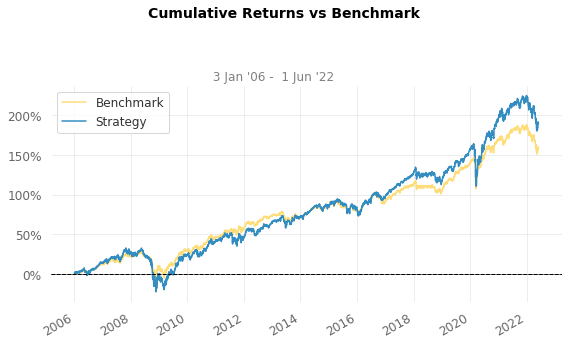

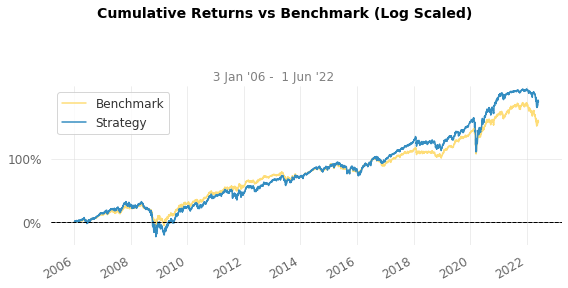

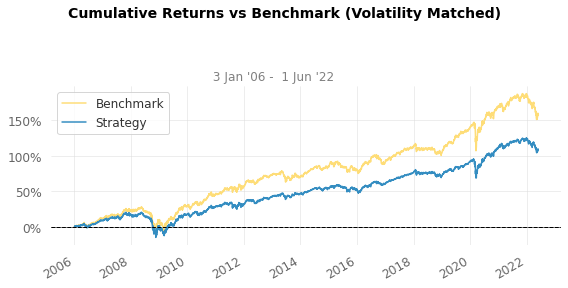

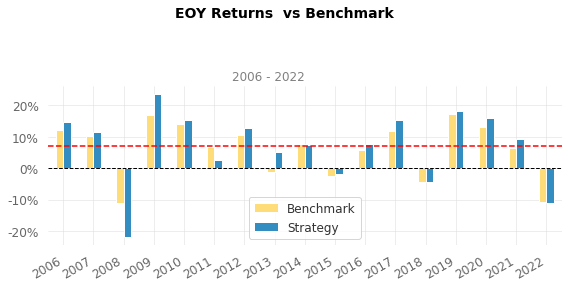

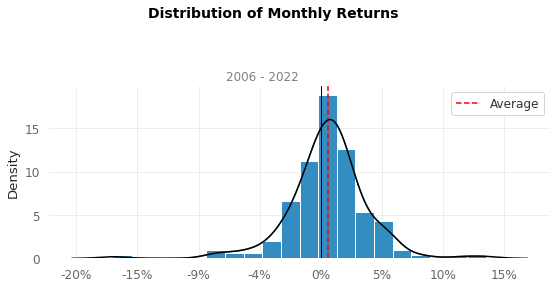

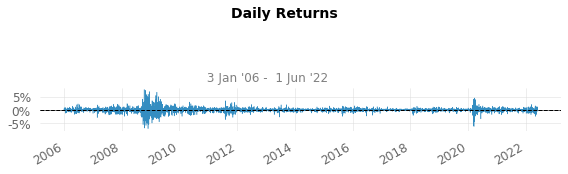

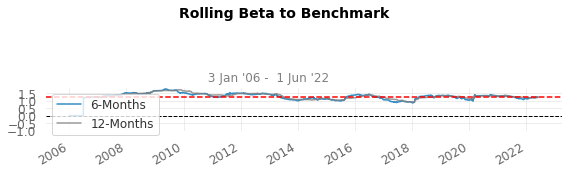

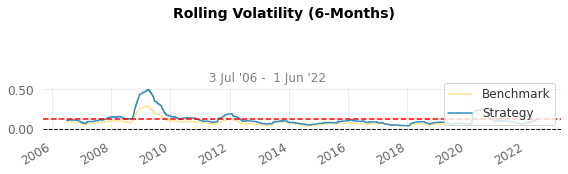

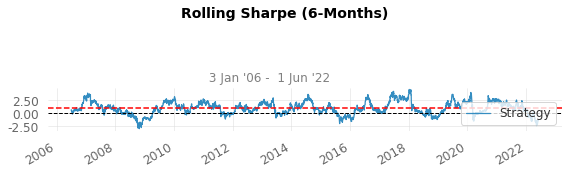

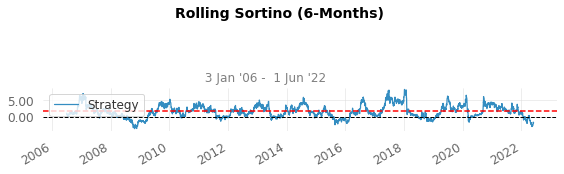

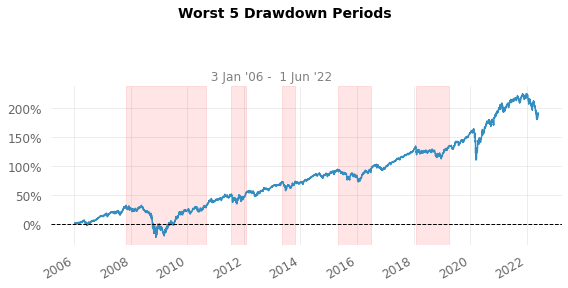

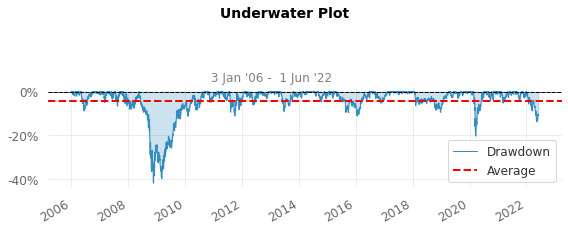

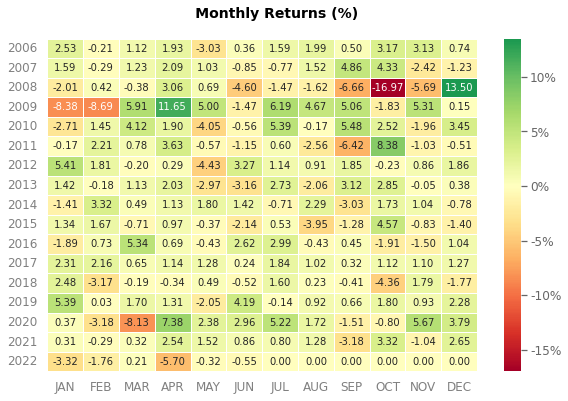

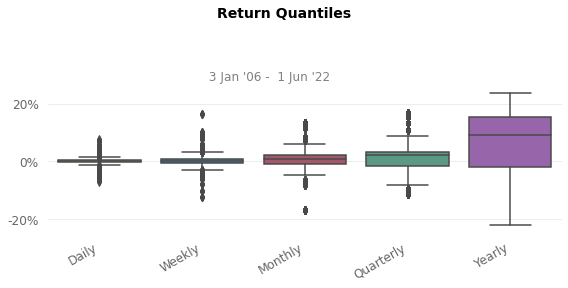

In [12]:
quantstats.reports.full(returns=my_strategy, benchmark=bm_strategy)

In [13]:
historical_portfolio = engine.asset_df
weight_historical_portfolio = pd.DataFrame(index=historical_portfolio.index, columns=historical_portfolio.columns)
for date in historical_portfolio.index:
    for ticker in historical_portfolio.columns:
        weight_historical_portfolio.loc[date,ticker] = historical_portfolio.loc[date,ticker]/historical_portfolio.loc[date].sum(axis=0)
weight_historical_portfolio

,cash,IEF,SHY,LQD,GLD,VNQ,EFA,EEM,SPY,TIP,TLT
2006-01-03,0.0,0.05,0.05,0.055784,0.064063,0.11728,0.125321,0.115263,0.3,0.05,0.072289
2006-01-04,0.0,0.049845,0.049805,0.055511,0.063966,0.117572,0.125745,0.11574,0.299948,0.049761,0.072108
2006-01-05,0.0,0.049872,0.049778,0.055575,0.062834,0.118512,0.125155,0.116366,0.300232,0.049632,0.072045
2006-01-06,0.0,0.049358,0.049342,0.054988,0.063909,0.118549,0.125698,0.117727,0.300004,0.049161,0.071264
2006-01-09,0.0,0.049176,0.049142,0.054769,0.064685,0.11906,0.125234,0.118386,0.299521,0.049013,0.071013
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-25,0.0,0.062988,0.054979,0.052047,0.079595,0.053903,0.08197,0.122383,0.291609,0.148426,0.0521
2022-05-26,0.0,0.062401,0.054505,0.0516,0.078744,0.053491,0.082141,0.123195,0.294801,0.147717,0.051405
2022-05-27,0.0,0.061743,0.053867,0.05125,0.077844,0.054269,0.082139,0.123128,0.298429,0.146416,0.050914
2022-05-31,0.0,0.061412,0.054058,0.051133,0.077468,0.053878,0.082067,0.125495,0.298274,0.146122,0.050092


<AxesSubplot:>

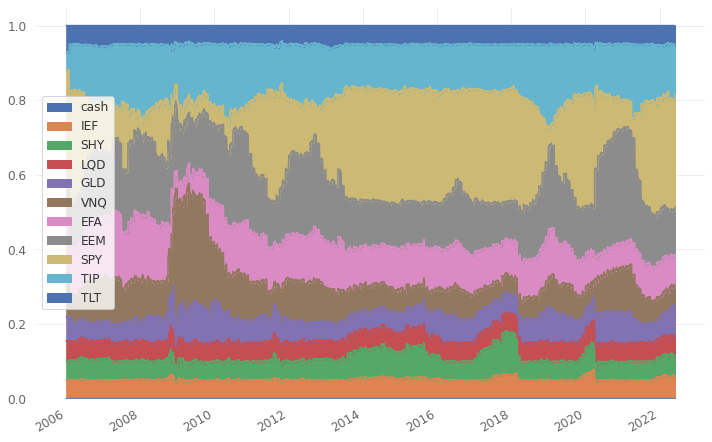

In [20]:
plt.rcParams["figure.figsize"] = (12, 8) # (width, height)
weight_historical_portfolio.plot.area()